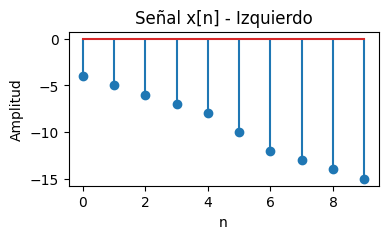

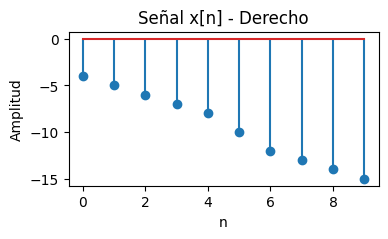

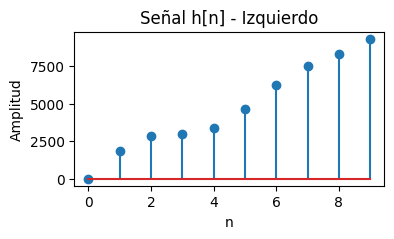

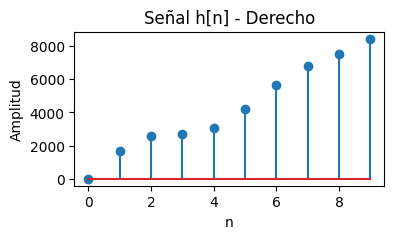

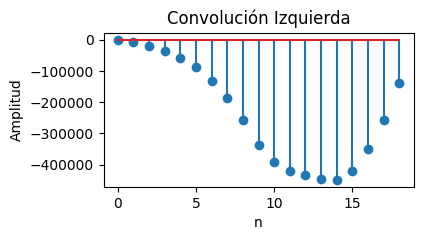

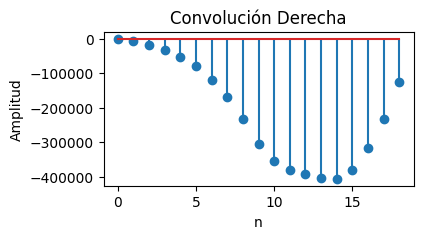

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import wave
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Función para leer los archivos WAV y verificar que sean estéreo, 44100 Hz, 16 bits
# Además, divide los canales izquierdo y derecho, y toma solo los primeros 10 valores
def leer_wav(nombre_archivo):
    with wave.open(nombre_archivo, 'rb') as wav_file:    #rb es lectura binaria. El bloque with se asegura de que el archivo se cierre automáticamente después de usarlo
        # Verificamos que el archivo tenga 2 canales (estéreo), frecuencia de 44100 Hz, y sea de 16 bits
        if wav_file.getnchannels() != 2 or wav_file.getframerate() != 44100 or wav_file.getsampwidth() != 2:
            raise ValueError("El archivo debe ser estéreo, 44100 Hz y 16 bits.")
        
        # Obtenemos el número de canales y frames del archivo
        n_canales = wav_file.getnchannels()
        n_frames = wav_file.getnframes() #Obtiene el número total de frames (muestras de audio) en el archivo
        
        # Leemos los datos brutos del archivo
        datos_brutos = wav_file.readframes(n_frames) #Lee todas las muestras de audio del archivo en su formato binario original
        
        # Convertimos los datos a un array NumPy de tipo int16 (16 bits)
        datos = np.frombuffer(datos_brutos, dtype=np.int16) #Convierte los datos crudos de audio en un array NumPy de enteros de 16 bits (int16)
        # Reshape para separar los canales (asumiendo estéreo)
        datos = np.reshape(datos, (-1, n_canales))
        canal_izquierdo = datos[:, 0][:10].astype(np.float64)  # Tomamos los primeros 10 datos del canal izquierdo en float 64
        canal_derecho = datos[:, 1][:10].astype(np.float64)    # Tomamos los primeros 10 datos del canal derecho en float 64
        
    return canal_izquierdo, canal_derecho

# Función para realizar la convolución manual de dos señales (x y h)
def convolucion_manual(x, h):
    N = len(x)  # Longitud de la señal x
    M = len(h)  # Longitud de la señal h
    y = np.zeros(N + M - 1, dtype=np.float64)  # Creamos un array de ceros para almacenar el resultado
    
    # Implementamos la convolución manualmente
    for n in range(N + M - 1):
        suma = 0
        for k in range(M):
            if 0 <= n - k < N:
                suma += x[n - k] * h[k]
        y[n] = suma
    
    return y

# Función para graficar una señal en un Frame de Tkinter usando matplotlib
def graficar_senal_en_tk(senal, titulo, frame, fig_size=(4, 2)):
    fig, ax = plt.subplots(figsize=fig_size)  # Creamos una figura y un eje
    ax.stem(senal)  # Usamos un gráfico de tipo stem (palitos)
    ax.set_title(titulo)  # Título del gráfico
    ax.set_xlabel("n")  # Etiqueta del eje X
    ax.set_ylabel("Amplitud")  # Etiqueta del eje Y
    
    # Integramos la figura en el Frame de Tkinter
    canvas = FigureCanvasTkAgg(fig, master=frame)
    canvas.draw()
    canvas.get_tk_widget().pack(pady=5)  # Empaquetamos el gráfico dentro del frame

# Función para mostrar el array de la señal en un widget Text con scroll horizontal
def mostrar_array_en_tk(array, frame, array_title="Array"):
    # Convertimos el array a una cadena de texto para poder mostrarlo
    array_str = np.array2string(array, separator=', ', max_line_width=80)
    
    # Creamos un Frame que contendrá el Text widget y la scrollbar
    frame_scroll = tk.Frame(frame)
    frame_scroll.pack(pady=5, fill=tk.X)  # Empaquetamos el frame horizontalmente
    
    # Creamos el widget Text para mostrar el contenido del array
    text_widget = tk.Text(frame_scroll, height=3, width=60, wrap=tk.WORD)
    
    # Añadimos una scrollbar horizontal
    scrollbar = tk.Scrollbar(frame_scroll, orient="horizontal", command=text_widget.xview)
    text_widget.configure(xscrollcommand=scrollbar.set)  # Sincronizamos el Text widget con la scrollbar
    
    # Insertamos el array dentro del widget Text
    text_widget.insert(tk.END, f"{array_title}: {array_str}")
    text_widget.pack(side=tk.TOP, fill=tk.X)  # Empaquetamos el Text widget
    
    # Empaquetamos la scrollbar debajo del Text widget
    scrollbar.pack(side=tk.BOTTOM, fill=tk.X)
    
    # Deshabilitamos la edición del Text widget para que sea solo lectura
    text_widget.config(state=tk.DISABLED)

# Función para procesar las señales y hacer la convolución
def procesar_senales():
    global x_izquierdo, x_derecho, h_izquierdo, h_derecho
    try:
        # Realizamos la convolución manual para ambos canales (izquierdo y derecho)
        y_manual_izq = convolucion_manual(x_izquierdo, h_izquierdo)
        y_manual_der = convolucion_manual(x_derecho, h_derecho)
        
        # Graficamos y mostramos los arrays de las convoluciones
        graficar_senal_en_tk(y_manual_izq, "Convolución Izquierda", frame_convolucion_izq)
        mostrar_array_en_tk(y_manual_izq, frame_convolucion_izq, array_title="Array de y[n] Izquierdo")
        
        graficar_senal_en_tk(y_manual_der, "Convolución Derecha", frame_convolucion_der)
        mostrar_array_en_tk(y_manual_der, frame_convolucion_der, array_title="Array de y[n] Derecho")
        
        messagebox.showinfo("Resultado de la convolución", "Convolución calculada correctamente.")
    except Exception as e:
        messagebox.showerror("Error", str(e))

# Función para cargar el archivo x[n] y graficar los canales izquierdo y derecho
def cargar_x():
    global x_izquierdo, x_derecho
    archivo_x = filedialog.askopenfilename(title="Selecciona archivo de audio x[n]",
                                           filetypes=[("Archivos WAV", "*.wav")])
    if archivo_x:
        try:
            # Leemos el archivo WAV y separamos los canales
            x_izquierdo, x_derecho = leer_wav(archivo_x)
            # Graficamos ambos canales
            graficar_senal_en_tk(x_izquierdo, "Señal x[n] - Izquierdo", frame_x_izq)
            graficar_senal_en_tk(x_derecho, "Señal x[n] - Derecho", frame_x_der)
            # Mostramos los arrays de los canales
            mostrar_array_en_tk(x_izquierdo, frame_x_izq, array_title="Array x[n] Izquierdo")
            mostrar_array_en_tk(x_derecho, frame_x_der, array_title="Array x[n] Derecho")
        except Exception as e:
            messagebox.showerror("Error", str(e))

# Función para cargar el archivo h[n] y graficar los canales izquierdo y derecho
def cargar_h():
    global h_izquierdo, h_derecho
    archivo_h = filedialog.askopenfilename(title="Selecciona archivo de audio h[n]",
                                           filetypes=[("Archivos WAV", "*.wav")])
    if archivo_h:
        try:
            # Leemos el archivo WAV y separamos los canales
            h_izquierdo, h_derecho = leer_wav(archivo_h)
            # Graficamos ambos canales
            graficar_senal_en_tk(h_izquierdo, "Señal h[n] - Izquierdo", frame_h_izq)
            graficar_senal_en_tk(h_derecho, "Señal h[n] - Derecho", frame_h_der)
            # Mostramos los arrays de los canales
            mostrar_array_en_tk(h_izquierdo, frame_h_izq, array_title="Array h[n] Izquierdo")
            mostrar_array_en_tk(h_derecho, frame_h_der, array_title="Array h[n] Derecho")
        except Exception as e:
            messagebox.showerror("Error", str(e))

# Función para salir de la aplicación
def salir():
    root.quit()

# Crear la ventana principal
root = tk.Tk()
root.title("Interfaz de Convolución de Señales")
root.geometry("1200x1000")  # Definimos el tamaño de la ventana

# Crear un frame para contener las gráficas y arrays
frame_graficas = tk.Frame(root)
frame_graficas.pack(side=tk.LEFT, padx=10, pady=10, fill=tk.BOTH, expand=True)

# Crear un frame para los botones
frame_botones = tk.Frame(root)
frame_botones.pack(side=tk.RIGHT, padx=10, pady=10)

# Crear subframes para los gráficos del canal izquierdo
frame_x_izq = tk.Frame(frame_graficas)
frame_x_izq.grid(row=0, column=0, padx=10, pady=10)

frame_h_izq = tk.Frame(frame_graficas)
frame_h_izq.grid(row=1, column=0, padx=10, pady=10)

frame_convolucion_izq = tk.Frame(frame_graficas)
frame_convolucion_izq.grid(row=2, column=0, padx=10, pady=10)

# Crear subframes para los gráficos del canal derecho
frame_x_der = tk.Frame(frame_graficas)
frame_x_der.grid(row=0, column=1, padx=10, pady=10)

frame_h_der = tk.Frame(frame_graficas)
frame_h_der.grid(row=1, column=1, padx=10, pady=10)

frame_convolucion_der = tk.Frame(frame_graficas)
frame_convolucion_der.grid(row=2, column=1, padx=10, pady=10)

# Botones para cargar los archivos de audio, procesar señales y salir
btn_cargar_x = tk.Button(frame_botones, text="Cargar archivo x[n]", command=cargar_x)
btn_cargar_x.pack(pady=10)

btn_cargar_h = tk.Button(frame_botones, text="Cargar archivo h[n]", command=cargar_h)
btn_cargar_h.pack(pady=10)

btn_procesar = tk.Button(frame_botones, text="Procesar Señal", command=procesar_senales)
btn_procesar.pack(pady=10)

btn_salir = tk.Button(frame_botones, text="Salir", command=salir)
btn_salir.pack(pady=10)

# Ejecutar la aplicación
root.mainloop()